# Imports

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [43]:
# Training Data
X = pd.read_csv('X.csv')

# Features
ys = pd.read_csv('ys.csv')

df = pd.concat([ys, X], axis=1)

# Make day sequential ints
df['day'] = range(1, len(df)+1)

# Baseline

## Today for tomorrow

In [45]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic
0,0.315732,0.090209
1,1.000000,0.315732
2,0.941694,1.000000
3,0.983498,0.941694
4,0.234323,0.983498


In [46]:
X = df_test.sr_gap_heuristic
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.2746893329253976

## Moving Average

In [47]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic_rolling_mean_expanding']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic_rolling_mean_expanding
0,0.315732,0.090209
1,1.000000,0.202970
2,0.941694,0.468647
3,0.983498,0.586909
4,0.234323,0.666227


In [48]:
X = df_test.sr_gap_heuristic_rolling_mean_expanding
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.24410813866050463

# Model Comparison

In [49]:
# Specify the start date
start_date = '2023-01-28'

# Determine the number of days based on the length of the DataFrame
num_days = len(df)

# Generate the date range
dates = pd.date_range(start=start_date, periods=num_days, freq='D')

# Create new column
df['date'] = dates

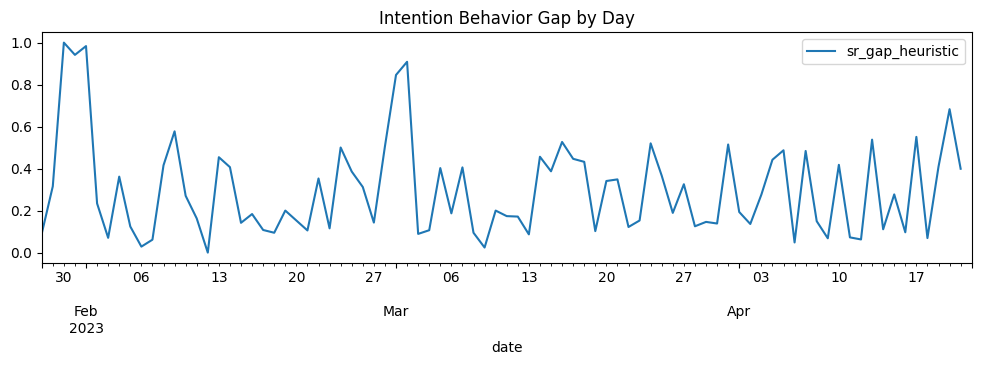

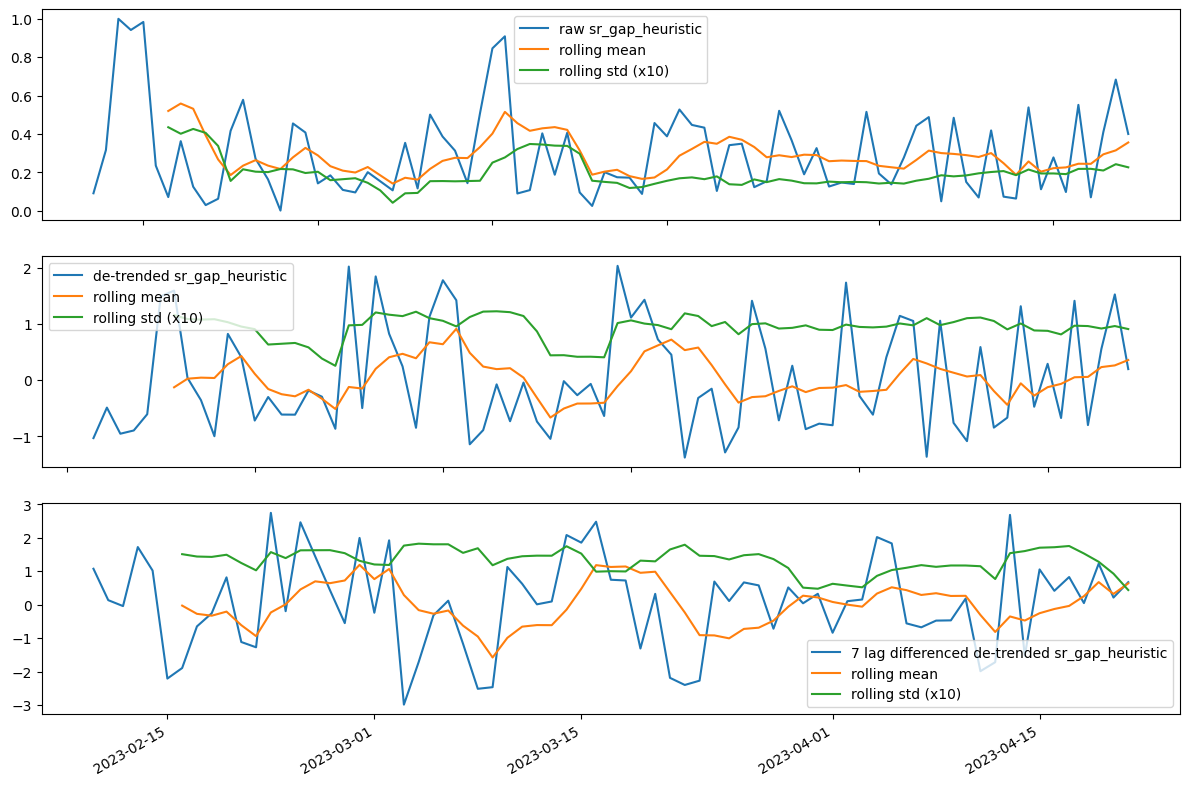

In [50]:
plt.style.use('default')
import matplotlib.dates as mdates

df_sub = pd.DataFrame(df, columns=['date','sr_gap_heuristic']).set_index('date')
df_sub = df_sub.asfreq('D') # Set the frequency to daily
train = df_sub.iloc[:-10, :]
test = df_sub.iloc[-10:, :]
pred = test.copy()
df_sub.plot(figsize=(12,3));
plt.title('Intention Behavior Gap by Day');

df_sub['z_sr_gap_heuristic'] = (df_sub['sr_gap_heuristic'] - df_sub.sr_gap_heuristic.rolling(window=7).mean()) / df_sub.sr_gap_heuristic.rolling(window=7).std()
df_sub['zp_sr_gap_heuristic'] = df_sub['z_sr_gap_heuristic'] - df_sub['z_sr_gap_heuristic'].shift(7)

def plot_rolling(df_sub):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df_sub.index, df_sub.sr_gap_heuristic, label='raw sr_gap_heuristic')
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df_sub.index, df_sub.z_sr_gap_heuristic, label="de-trended sr_gap_heuristic")
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df_sub.index, df_sub.zp_sr_gap_heuristic, label="7 lag differenced de-trended sr_gap_heuristic")
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df_sub)

## Traditional

### ARIMA/SARIMA

#### Stationarity

The cleaned time series passed the Augmented Dickey-Fuller (ADF) test, indicating that it is stationary. The test statistic 
−6.73 is well below the critical values, and the very small p-value (3.27×10−9) strongly rejects the null hypothesis of a unit root (non-stationarity).

Given that the data is stationary we can set the integrated term, `d` to 0.

In [51]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df_sub.sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df_sub.z_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 7-lag differenced de-trended data stationary ?")
dftest = adfuller(df_sub.zp_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -6.733
P-value = 0.000
Critical values :
	1%: -3.5117123057187376 - The data is  stationary with 99% confidence
	5%: -2.8970475206326833 - The data is  stationary with 95% confidence
	10%: -2.5857126912469153 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -8.169
P-value = 0.000
Critical values :
	1%: -3.518281134660583 - The data is  stationary with 99% confidence
	5%: -2.899878185191432 - The data is  stationary with 95% confidence
	10%: -2.5872229937594873 - The data is  stationary with 90% confidence

 > Is the 7-lag differenced de-trended data stationary ?
Test statistic = -4.556
P-value = 0.000
Critical values :
	1%: -3.548493559596539 - The data is  stationary with 99% confidence
	5%: -2.912836594776334 - The data is  stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence


                               SARIMAX Results                                
Dep. Variable:       sr_gap_heuristic   No. Observations:                   84
Model:                          ARIMA   Log Likelihood                   4.483
Date:                Wed, 01 May 2024   AIC                             -4.966
Time:                        12:39:08   BIC                             -0.104
Sample:                    01-28-2023   HQIC                            -3.012
                         - 04-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2990      0.033      8.930      0.000       0.233       0.365
sigma2         0.0526      0.009      6.137      0.000       0.036       0.069
Ljung-Box (L1) (Q):                   7.10   Jarque-

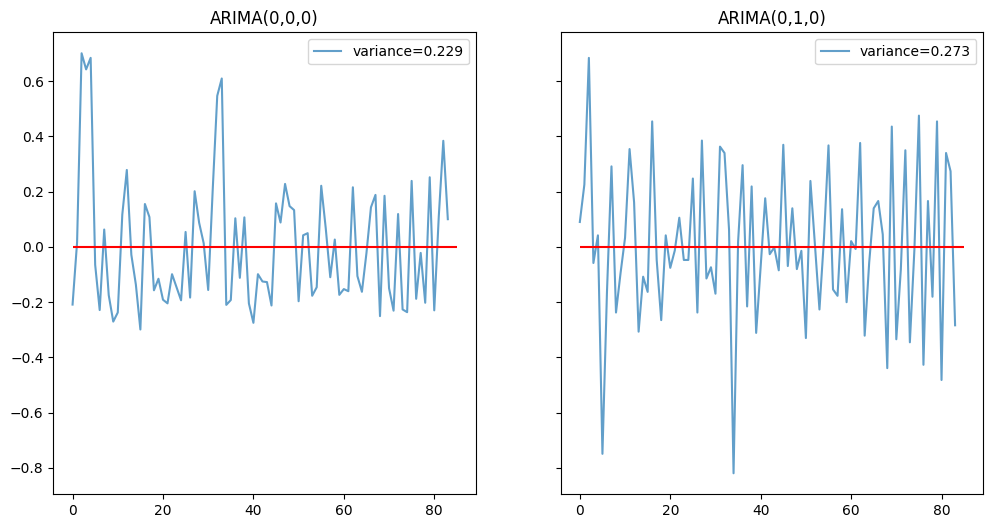

In [52]:
# Alt method for showing stationarity

from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=85, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=85, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

#### Autocorrelation

Given the `PACF` function does not have any significant correlations we can set this value (`p`) to zero


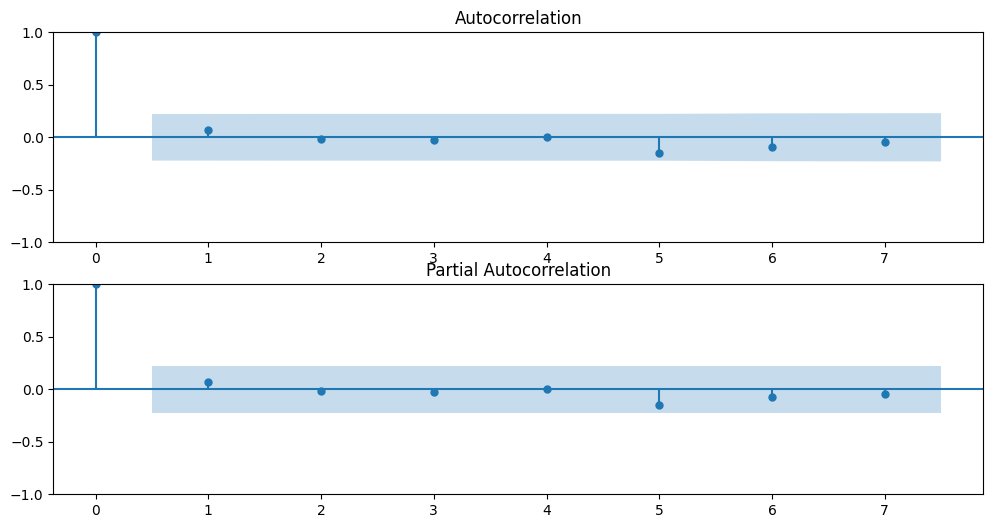

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[1], lags=7)

#### Predictive Model

The notation ARIMA(p, d, q) represents a specific configuration of the ARIMA model, which stands for AutoRegressive Integrated Moving Average. Let’s break down what each of these parameters represents in the context of ARIMA(1,0,1):

1. **p (AR part) - Autoregressive Term:**
- p = 1: This indicates that the model includes one lag of the series in the prediction. In other words, the model uses the first previous value to predict the current value. This part of the model captures the relationship between a given value and its predecessors.
2. **d (I part) - Integrated Term:**
- d = 0: This specifies the degree of differencing involved. Since d is 0, it means no differencing is needed, suggesting that the time series is already stationary. Differencing is a method of transforming a time series dataset to make it stationary, which is often necessary for ARIMA modeling as it relies on the assumption of stationarity.
3. **q (MA part) - Moving Average Term:**
- q = 1: This indicates that the model uses one moving average term. This part involves the error term of the model’s lagged forecasts. Essentially, it allows the model to account for the relationship between an observation and a residual error from a moving average model applied to lagged observations.

In [54]:
from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

p = 0 # autoregressive term
d = 0 # integrated term
q = 0 # moving avearge term

# Split the data into train and test sets for ARIMA model fitting and forecasting
train_size_cleaned = int(len(df) * 0.8)
train_cleaned, test_cleaned = df['sr_gap_heuristic'][:train_size_cleaned], df['sr_gap_heuristic'][train_size_cleaned:]

# Fit the ARIMA model (using ARIMA(X,0,1) as an example configuration)
model_cleaned = ARIMA(train_cleaned, order=(p, d, q))
fitted_model_cleaned = model_cleaned.fit()

# Forecast on the test data
forecast_cleaned = fitted_model_cleaned.forecast(steps=len(test_cleaned))

# Calculate RMSE
mask = ~np.isnan(test_cleaned) & ~np.isnan(forecast_cleaned) # remove NaN values
rmse_cleaned = np.sqrt(mean_squared_error(test_cleaned[mask], forecast_cleaned[mask]))
rmse_cleaned, forecast_cleaned.head()

(0.21179911705509147,
 68    0.304124
 69    0.304124
 70    0.304124
 71    0.304124
 72    0.304124
 Name: predicted_mean, dtype: float64)

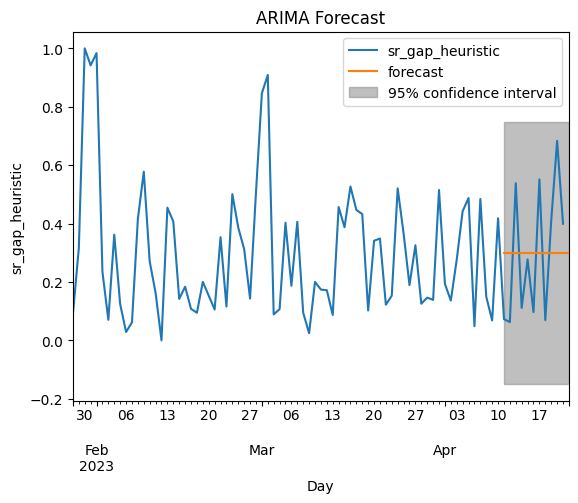

In [56]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

res = ARIMA(df_sub['sr_gap_heuristic'], order=(0,0,0)).fit()

fig, ax = plt.subplots()
ax = df_sub['sr_gap_heuristic'].plot(ax=ax)
plot_predict(res, '2023-04-11', '2023-04-22', ax=ax)
plt.title('ARIMA Forecast')
plt.xlabel('Day')
plt.ylabel('sr_gap_heuristic')
plt.show()

### Exponential Smoothing

The RMSE of the model is: 0.2448171326616217


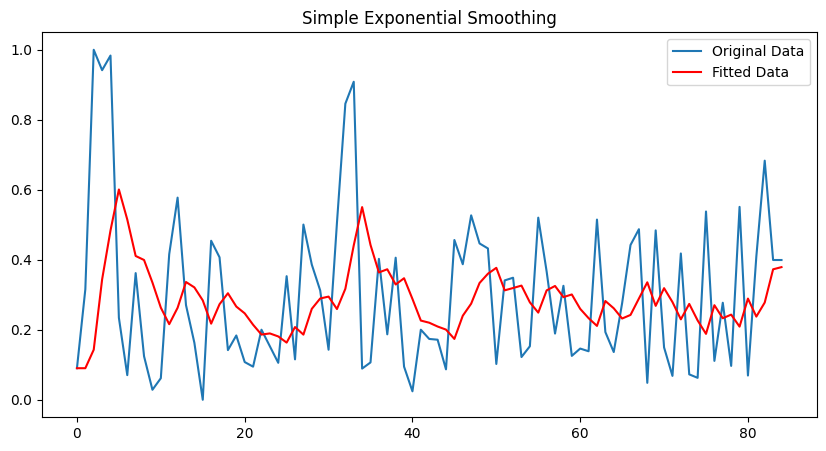

In [57]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

series = df['sr_gap_heuristic']  # replace 'your_time_series_column' with the name of your column

# Optionally, handle missing values if necessary
series.fillna(method='ffill', inplace=True)  # forward fill to handle NaNs

# Initialize the model
model = SimpleExpSmoothing(series)

# Fit the model
fitted_model = model.fit(optimized=True)  # Let the model optimize the smoothing level

# Predict on the in-sample data
predictions = fitted_model.fittedvalues

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(series, predictions))
print("The RMSE of the model is:", rmse)

plt.figure(figsize=(10, 5))
plt.plot(series, label='Original Data')
plt.plot(predictions, label='Fitted Data', color='red')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

## Machine Learning

### Gradient Boosting

In [58]:
# need to drop tailing rows since no y1 value
df.y1.tail()

80    0.409241
81    0.683168
82    0.399340
83         NaN
84         NaN
Name: y1, dtype: float64

In [64]:
df_copy = df.copy()
df_copy = df_copy.iloc[:-2]

In [68]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Prepare features and target
X = df_copy.drop(['y1', 'y2', 'y3', 'date'], axis=1)  # exclude the future values of gap
y = df_copy['y1'] # 1 day in future

# Splitting the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Initialize the model
model = HistGradientBoostingRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Using cross-validation to evaluate the model
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("Cross-validated RMSE: ", np.mean(rmse_scores))

[0.41969293 0.2201704  0.27078455 0.27499121 0.16837421]
Cross-validated RMSE:  0.27080266049335633


In [69]:
# Predicting on test set
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", test_rmse)

Test RMSE:  0.21823006940631903


#### Prediction

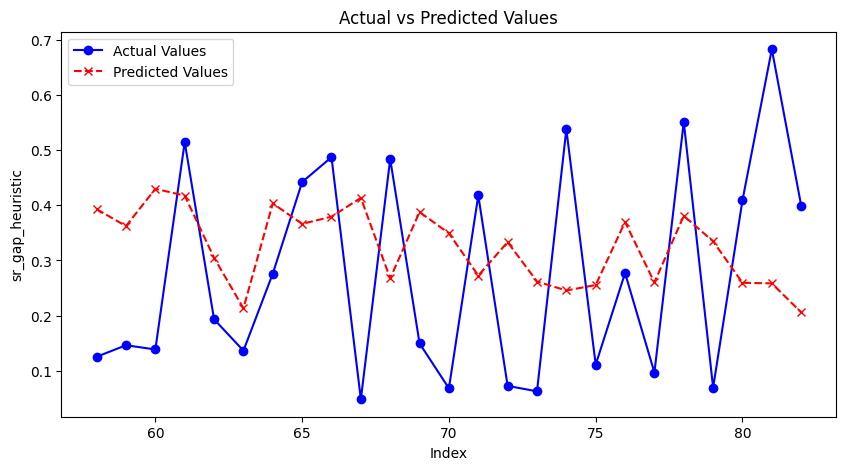

In [70]:
# Create a DataFrame from y_test for easy plotting
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Actual Values', color='blue', marker='o')
plt.plot(test_results['Predicted'], label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('sr_gap_heuristic')
plt.legend()
plt.show()

#### Feature Importance

In [71]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Store the importances in a DataFrame for easier plotting
importance_df = pd.DataFrame({'features': X.columns, 'importance_mean': result.importances_mean})
importance_df.sort_values(by='importance_mean', ascending=False, inplace=True)

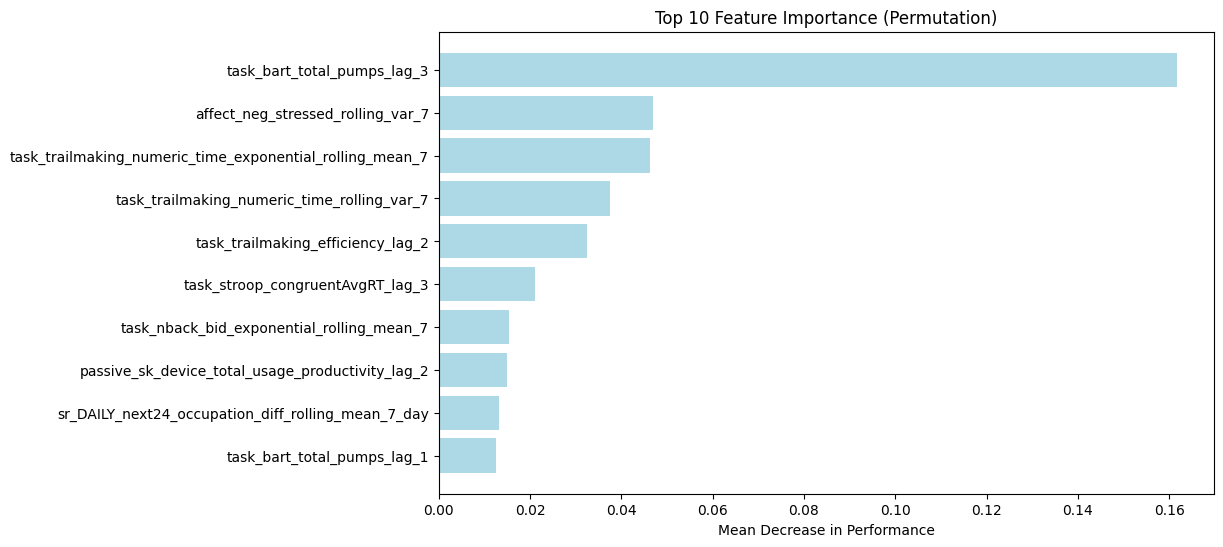

In [72]:
# Selecting the top 10 most important features
top_10_features = importance_df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['features'], top_10_features['importance_mean'], color='lightblue')
plt.xlabel('Mean Decrease in Performance')
plt.title('Top 10 Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

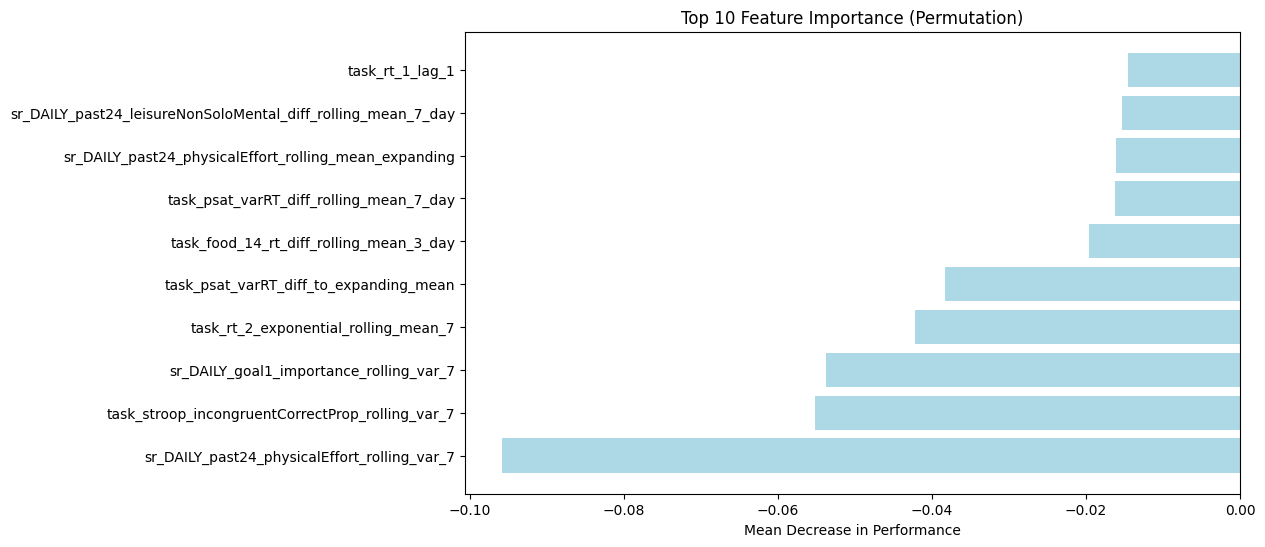

In [247]:
# Selecting the top 10 most important features
top_10_features = importance_df.tail(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['features'], top_10_features['importance_mean'], color='lightblue')
plt.xlabel('Mean Decrease in Performance')
plt.title('Top 10 Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

### SVM

In [86]:
print(df_copy.shape)

# Calculate the percentage of NaNs in each column
nan_percentage = df_copy.isna().mean()

# Filter out columns with more than 50% NaN values
df_copy_filtered = df_copy.loc[:, nan_percentage <= 0.5]

df_copy_filtered.shape

(83, 3323)


(83, 3288)

In [75]:
y.shape

(83,)

In [92]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



# Prepare features and target
X = df_copy_filtered.drop(['y1', 'y2', 'y3', 'date'], axis=1)  # exclude the future values of gap
y = df_copy_filtered['y1'] # 1 day in future

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change 'mean' to 'median' or 'most_frequent' if needed
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))  # Starting with a linear kernel
])

param_grid = {
    'imputer__strategy': ['mean', 'median'],  # Exploring different imputation strategies    
    'svr__kernel': ['linear', 'rbf'],  # Include different kernels to test
    'svr__C': [0.01, 0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    'svr__gamma': ['scale', 'auto']  # For RBF kernel
}

# Grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

Best parameters: {'imputer__strategy': 'mean', 'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Best cross-validation score: 0.06


In [100]:
grid_search.best_score_

-0.05992909301448805

In [93]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate RMSE for the test set predictions
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 0.1924573299782489


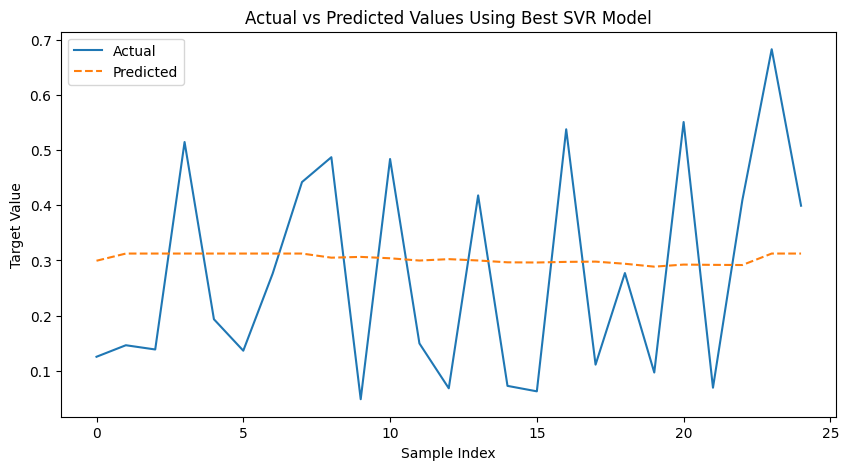

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Values Using Best SVR Model')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [90]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract importance and feature names
importance_sorted_idx = perm_importance.importances_mean.argsort()

# Additional Notes:
# Kernel Choice: The choice of kernel in the SVM can affect which features appear more important, especially if non-linear kernels are used.
# Scaling and Impact: Ensure that all features are scaled (as SVMs are sensitive to the scale of the input features), as this can impact the computed importance.
# Permutation Importance Considerations: This method can be computationally intensive, especially with a large number of repeats and features. Adjust n_repeats for a balance between runtime and reliability.
# This approach will give you a visual understanding of which features are most influential to your SVM model, even though SVMs don't intrinsically provide feature importance metrics.

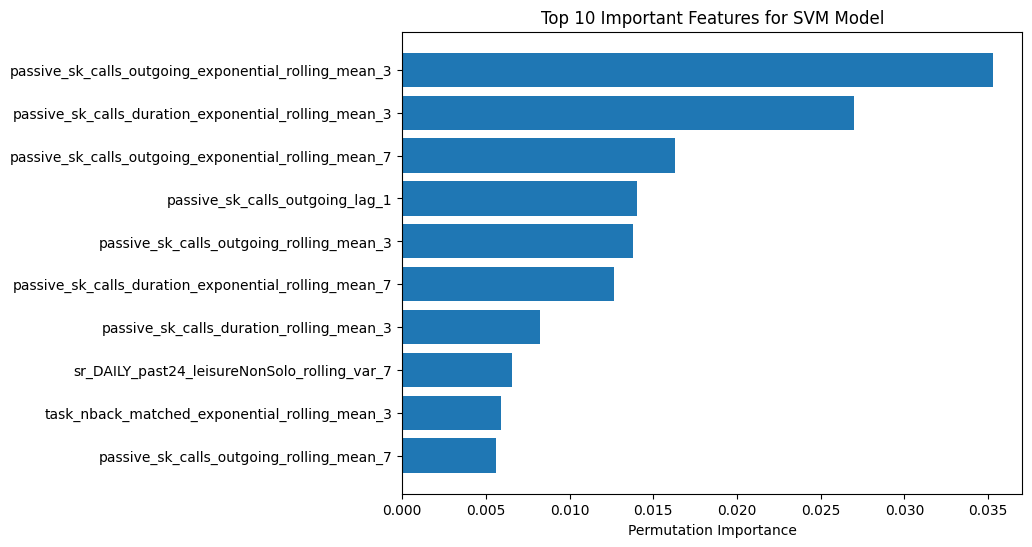

In [91]:
# Top 10 most important features
top_idx = importance_sorted_idx[-10:]

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_idx)), perm_importance.importances_mean[top_idx], align='center')
plt.yticks(range(len(top_idx)), [X.columns[i] for i in top_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Important Features for SVM Model')
plt.show()

## Deep Learning

### LSTM

In [148]:
df_lstm = df.copy()
df_lstm.drop([col for col in df.columns if '_rolling_mean_' in col], axis=1, inplace=True)
df_lstm.drop([col for col in df.columns if '_lag_' in col], axis=1, inplace=True)
df_lstm.drop([col for col in df.columns if '_rolling_var_' in col], axis=1, inplace=True)
df_lstm.drop([col for col in df.columns if '_expanding_mean' in col], axis=1, inplace=True)

In [149]:
df_lstm.drop(['y1', 'y2', 'y3', 'day',
              'task_rt_1', 'task_rt_2',
              'task_rt_3', 'task_rt_4'], axis=1, inplace=True)

In [150]:
df_lstm.set_index('date', inplace=True)

In [151]:
df_lstm.shape

(85, 233)

<Axes: >

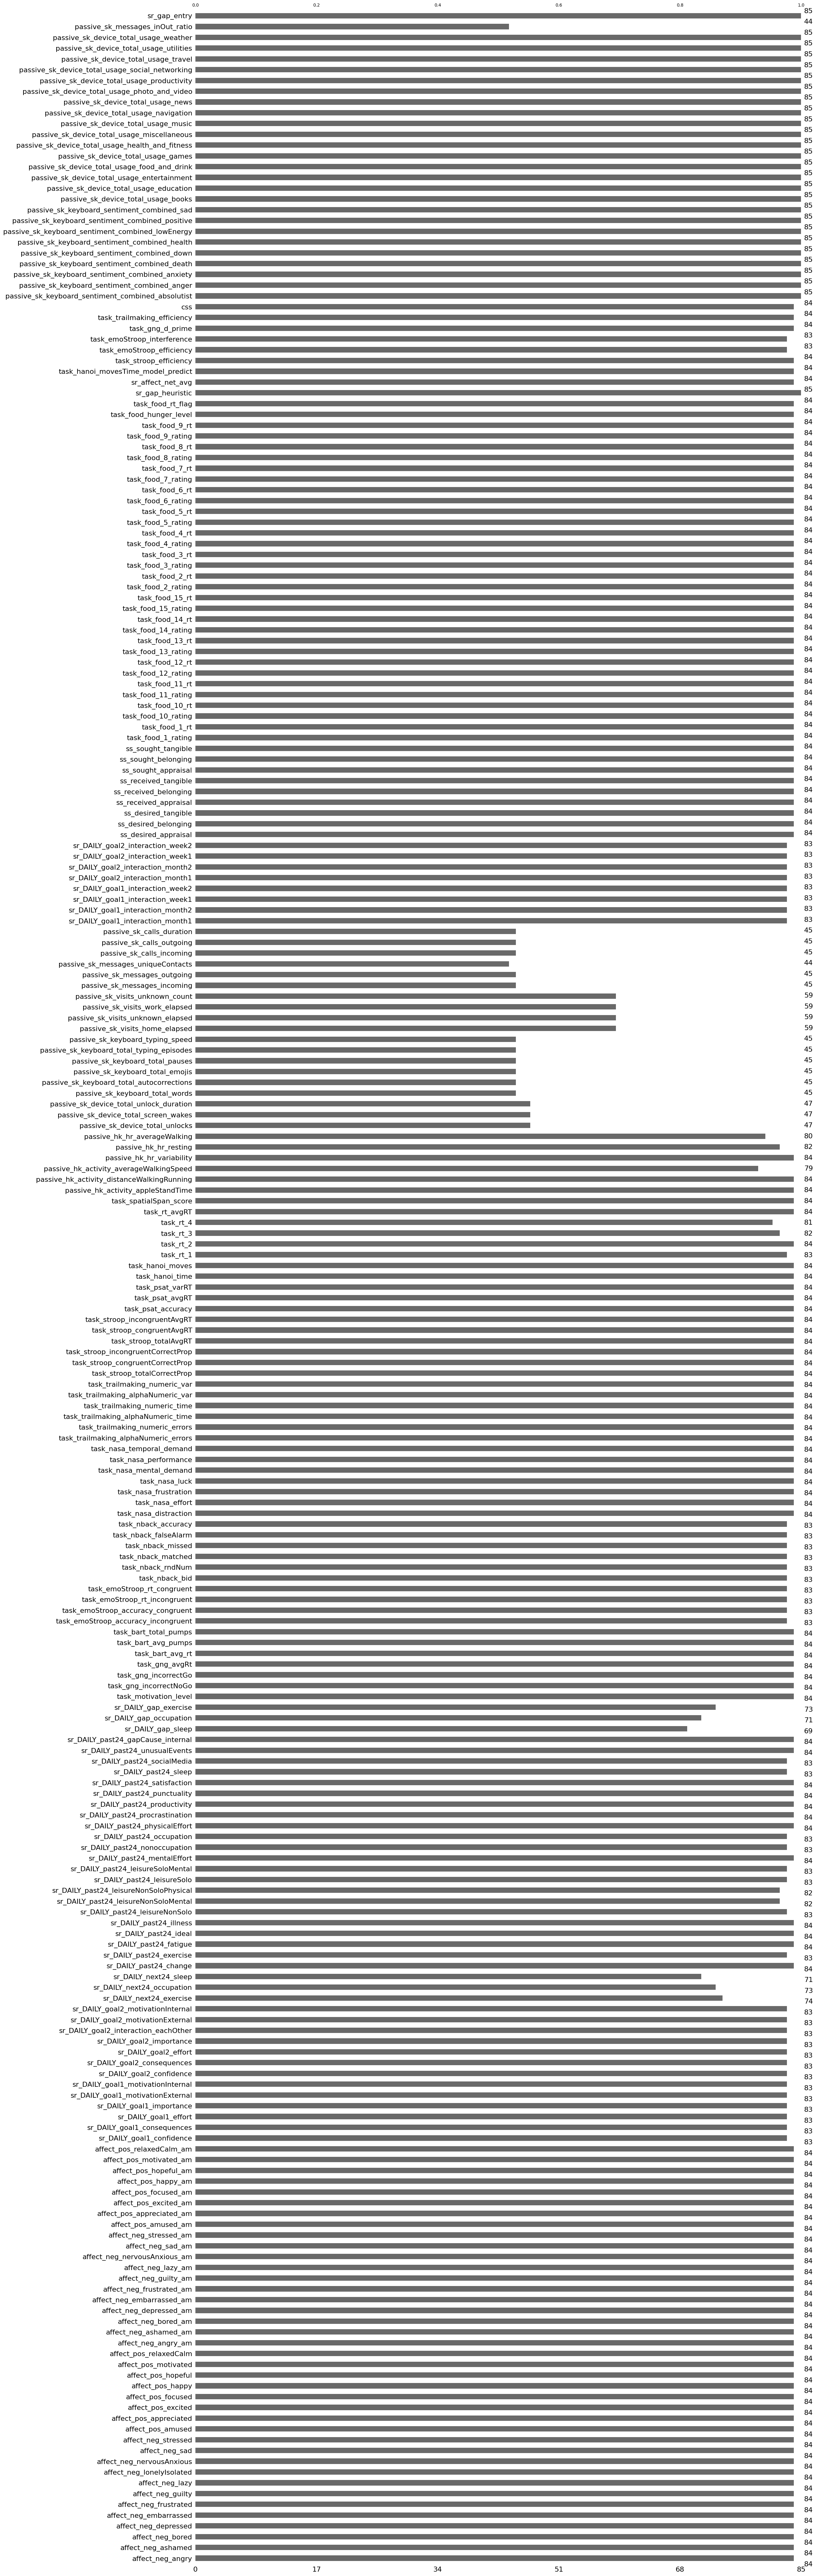

In [147]:
import missingno as msno
msno.bar(df_lstm)

In [167]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Constants
sequence_length = 10  # Using the last 10 days to predict the next day

# Fill missing values with the mean of each column
df_filled = df_lstm.fillna(df_lstm.mean())

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df_filled), columns=df_filled.columns, index=df_filled.index)

# Preparing data for LSTM
def create_sequences(data, target_column, sequence_length=10):
    sequences = []
    labels = []
    data_values = data.values
    for i in range(len(data) - sequence_length):
        sequences.append(data_values[i:i+sequence_length])
        labels.append(data_values[i+sequence_length][data.columns.get_loc(target_column)])
    return np.array(sequences), np.array(labels)

# Create sequences
X, y = create_sequences(df_scaled, 'sr_gap_heuristic', sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 10, 233), (15, 10, 233), (60,), (15,))

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach as we are making a new forward pass. 
        # We don't want to backprop through the entire history.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :]) 
        return out

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')  # Save the model checkpoint
        self.val_loss_min = val_loss

# Model dimensions
input_dim = X_train.shape[2]
hidden_dim = 64  # Can be tuned
num_layers = 2   # Can be tuned
output_dim = 1

# Create the model
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Display model summary
model

LSTMModel(
  (lstm): LSTM(233, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Validation loss decreased (inf --> 0.378258).  Saving model ...
Epoch 1, Train Loss: 0.1137, Test Loss: 0.3783
Validation loss decreased (0.378258 --> 0.065149).  Saving model ...
Epoch 2, Train Loss: 0.3920, Test Loss: 0.0651
EarlyStopping counter: 1 out of 7
Epoch 3, Train Loss: 0.0593, Test Loss: 0.1015
EarlyStopping counter: 2 out of 7
Epoch 4, Train Loss: 0.0943, Test Loss: 0.0841
Validation loss decreased (0.065149 --> 0.063026).  Saving model ...
Epoch 5, Train Loss: 0.0771, Test Loss: 0.0630
Validation loss decreased (0.063026 --> 0.047072).  Saving model ...
Epoch 6, Train Loss: 0.0568, Test Loss: 0.0471
Validation loss decreased (0.047072 --> 0.041792).  Saving model ...
Epoch 7, Train Loss: 0.0416, Test Loss: 0.0418
EarlyStopping counter: 1 out of 7
Epoch 8, Train Loss: 0.0370, Test Loss: 0.0489
EarlyStopping counter: 2 out of 7
Epoch 9, Train Loss: 0.0446, Test Loss: 0.0508
EarlyStopping counter: 3 out of 7
Epoch 10, Train Loss: 0.0463, Test Loss: 0.0461
EarlyStopping count

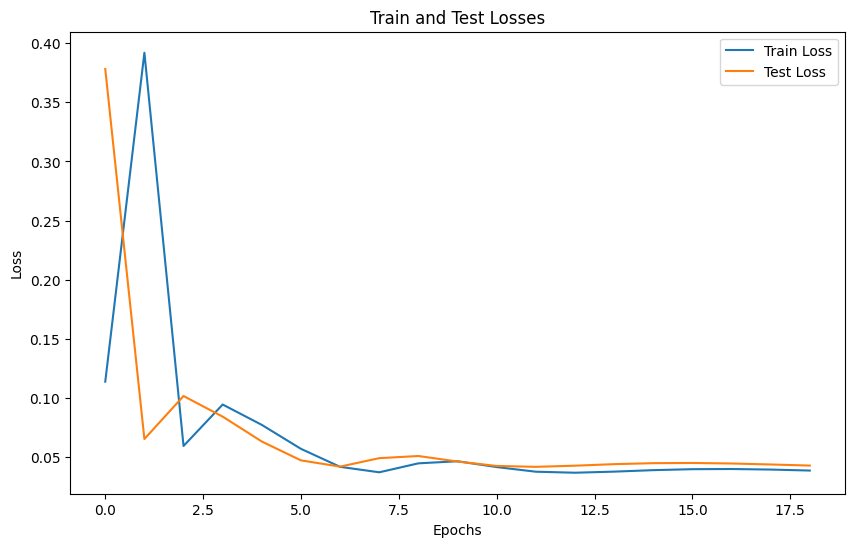

In [175]:
# Training the model
num_epochs = 100
train_losses = []
test_losses = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=7, verbose=True)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        test_loss = criterion(test_output.squeeze(), y_test_tensor)
        test_losses.append(test_loss.item())
    
    # Early stopping logic
    early_stopping(test_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print(f'Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plotting the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


In [176]:
# Load the last best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [178]:
model.eval() # Set the model to evaluation mode

with torch.no_grad():
    test_output = model(X_test_tensor)

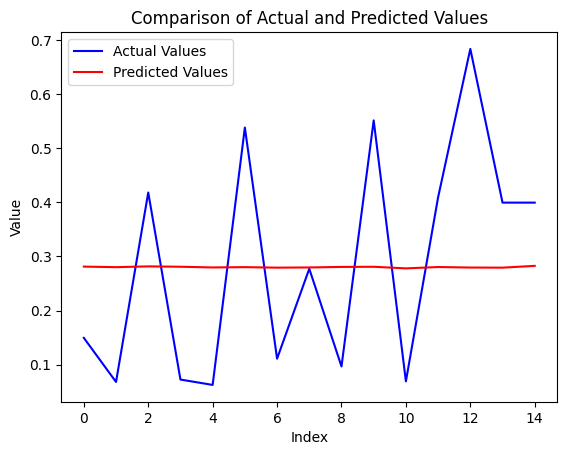

In [180]:
# Plot
plt.plot(y_test_tensor, label='Actual Values', color='blue')
plt.plot(test_output, label='Predicted Values', color='red')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()